In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
import sympy as sym
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

## 切比雪夫多项式根

In [21]:
def chebP(N):
    t =  np.linspace(0,np.pi,N)
    x = np.cos(t)
    return x

## Legendre多项式根

In [22]:
def jp(N,alpha,beta):
    n = np.arange(1,N+1)
    a = np.zeros(N+1)
    b = np.zeros(N+1)
    a[0] = (alpha+beta+2)/2
    b[0] = (beta-alpha)/2
    a[1:] = (2*n+alpha+beta+1)*(2*n+alpha+beta+2)/(2*(n+1)*(n+alpha+beta+1))
    b[1:] = (alpha*alpha-beta*beta)*(2*n+alpha+beta+1)/(2*(n+1)*(n+alpha+beta+1)*(2*n+alpha+beta))
    c=(n+alpha)*(n+beta)*(2*n+alpha+beta+2)/((n+1)*(n+alpha+beta+1)*(2*n+alpha+beta))
    A=np.diag(b/a)+np.diag(1/a[:-1],1)+np.diag(c/a[1:],-1)
    x,_ = np.linalg.eig(A)
    x = np.sort(x)
    return x
def legendreP(N,alpha=0,beta=0,m=0):
    '''
    默认：
    alpha=0
    beta=0
    m为几阶导的零点，默认为0
    '''
    N1 = N-m-1
    alpha1 = alpha+m
    beta1 = beta+m
    x = jp(N1,alpha1,beta1)
    return x

## Lagrange插值

In [23]:
# 拉格朗日函数
def lagrange(x, X, Y):
    if len(X) != len(Y):
        raise ValueError("输入的插值节点X变量与Y变量长度不对应！")
    if type(x) == int:
        x = [x]
    Y = np.array(Y)
    n = len(X)
    y = []
    # 求所有待估计点
    for xi in x:
        # 定义l保存l_1,l_2,...l_n
        l = np.ones(n)
        for i in range(n):
            for ii in range(n):
                if i != ii:
                    l[i] = l[i] * (xi - X[ii]) / (X[i] - X[ii])
        yi = Y @ l
        y.append(yi)
    y = np.array(y)
    return y

## Hermite插值

In [24]:
# Hermite插值
def taylor_expan(func, xx, num_terms):
    '''
    泰勒展开函数
    func:符号变量函数，自变量为x
    num_terms:展开的次数
    xx:展开的位置
    '''
    x = sym.Symbol('x')
    sums = 0
    for i in range(num_terms + 1):
        # 求i次导数
        numerator = func.diff(x, i)
        # 导数在xx点的值（泰勒展开分子）
        numerator = numerator.evalf(subs={x: xx})
        # i的阶乘
        denominator = np.math.factorial(i)
        # 累加项
        sums += numerator / denominator * (x - xx) ** i
    return sums


def A_(x, X, m):
    '''
    x:符号变量
    X:插值节点
    m:给定的mi阶导信息
    '''
    x = sym.Symbol('x')
    out = 1
    for i, mi in enumerate(m):
        out *= (x - X[i]) ** mi
    return out


def hermite(x_i, X, Y):
    '''
    x_i:待插值节点
    X:插值节点
    Y:插值节点值
    '''
    x_i = np.array(x_i)
    X = np.array(X)
    Y = np.array(Y)
    # 插值点数
    k = len(X)
    # 给定的mi阶导信息
    flag = np.isnan(Y) == False
    m = flag.sum(axis=0)
    # 求mi-j-1阶泰勒展开
    x = sym.Symbol('x')
    A = A_(x, X, m)
    hermite_out = 0
    for i in range(k):
        for j in range(m[i]):
            func_1 = A / (x - X[i]) ** m[i]
            func_2 = (x - X[i]) ** m[i] / A
            taylor = taylor_expan(func_2, X[i], m[i] - j - 1)
            fji = Y[j, i]
            hermite_out += func_1 * fji * (x - X[i]) ** j / np.math.factorial(j) * taylor
    out = sym.lambdify('x', hermite_out, "numpy")
    return out(x_i)

## 绘图函数

In [25]:
def plot(x,y,label):
    plt.plot(x,y,label='function')
    plt.legend(loc='best')
    plt.show()

## 插值函数

In [26]:
# 1 龙格函数 y = 1/(1+25*x^2)
def runge(x):
    x = np.array(x)
    y = 1/(1+25*x**2)
    return y

In [30]:
# 原函数值
X = np.linspace(-1, 1, 200)
Y = runge(X)

## 同时进行等距牛顿插值和Hermite插值，比较结果

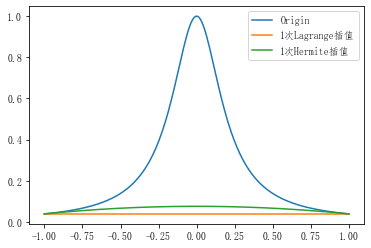

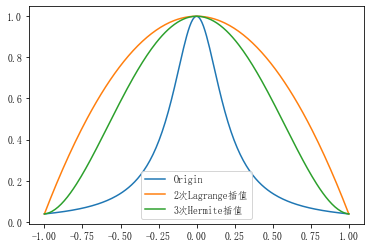

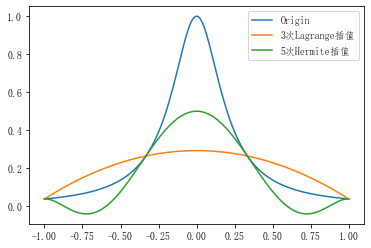

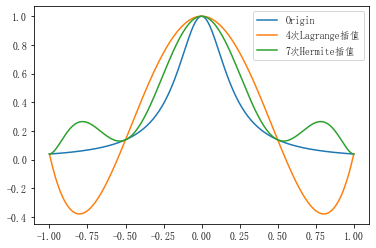

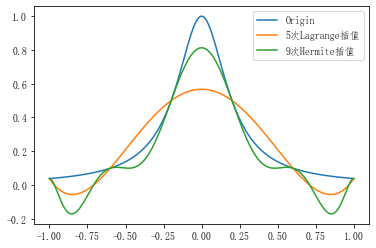

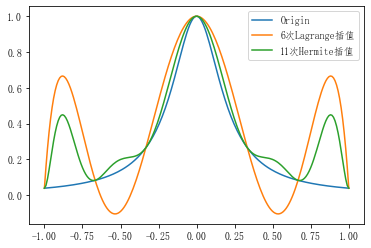

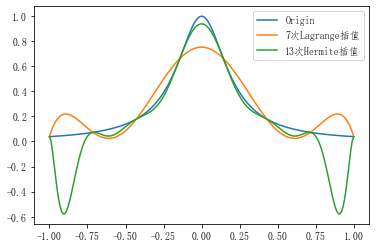

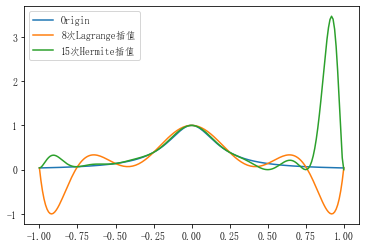

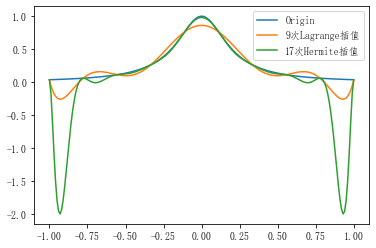

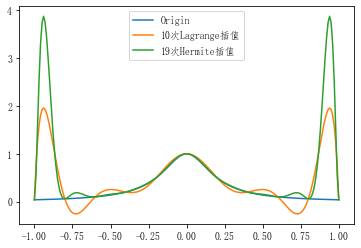

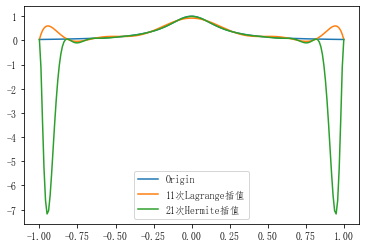

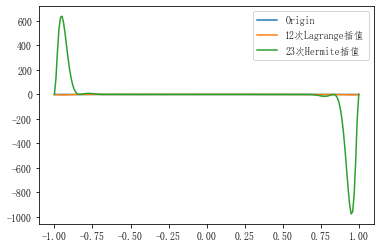

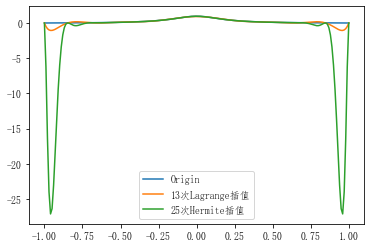

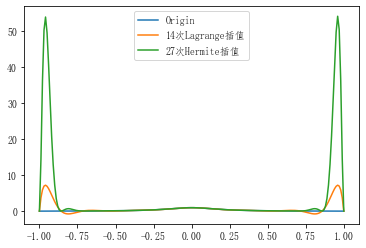

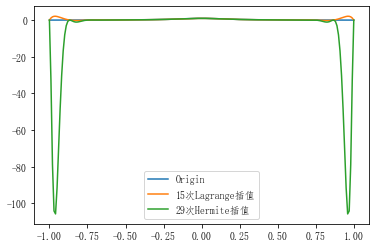

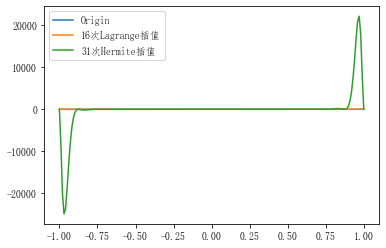

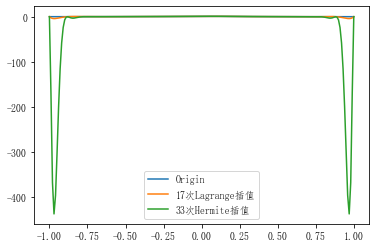

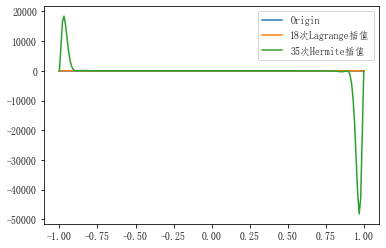

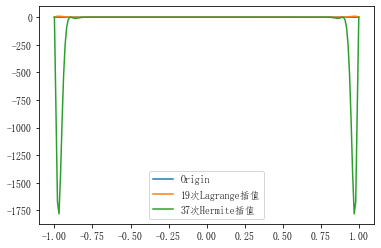

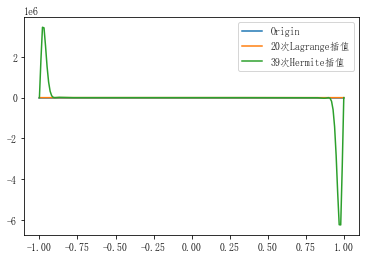

<Figure size 432x288 with 0 Axes>

In [31]:
N = 20
for n in range(N):
    # Lagrange 插值
    X1 = np.linspace(-1, 1, n + 2)
    Y1 = 1 / (1 + 25 * X1 ** 2)
    x1 = np.linspace(-1, 1, 200)
    y1 = lagrange(x1, X1, Y1)
    # Hermite 插值
    X2 = X1
    Y_2 = -50*X2 / (1 + 25 * X2 ** 2)**2
    Y2 = np.array([Y1,Y_2])
    x2 = np.linspace(-1, 1, 200)
    y2 = hermite(x2,X2,Y2)
    plt.plot(X, Y, label='Origin')
    plt.plot(x1, y1, label=str(n+1) + '次Lagrange插值')
    plt.plot(x2, y2, label=str(2*n+1) + '次Hermite插值')
    plt.legend(loc='best')
    plt.show(block=False)
    plt.pause(1)
    plt.clf()

## 针对牛顿插值，分别比较等距节点、切比雪夫节点、Legendre多项式根节点在[-1,1]插值的区别

[-0.57735027  0.57735027]


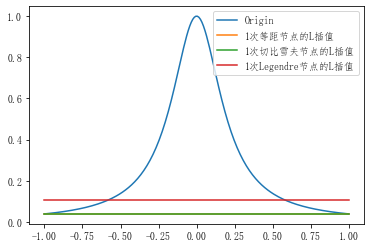

[-7.74596669e-01  4.33680869e-19  7.74596669e-01]


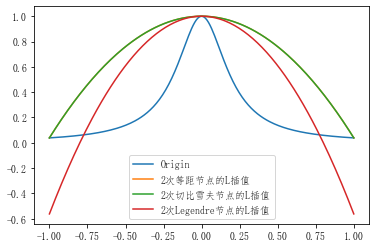

[-0.86113631 -0.33998104  0.33998104  0.86113631]


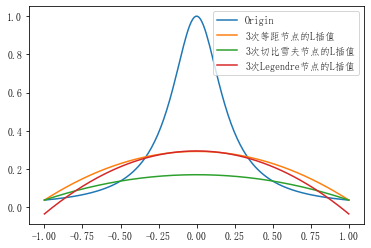

[-9.06179846e-01 -5.38469310e-01 -2.35690992e-17  5.38469310e-01
  9.06179846e-01]


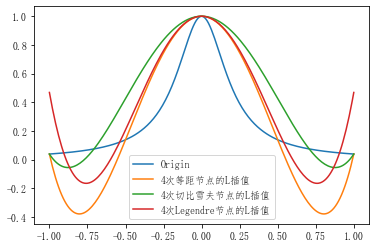

[-0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939  0.93246951]


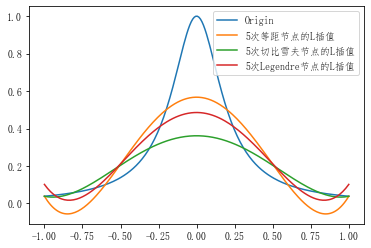

[-9.49107912e-01 -7.41531186e-01 -4.05845151e-01  6.33376116e-17
  4.05845151e-01  7.41531186e-01  9.49107912e-01]


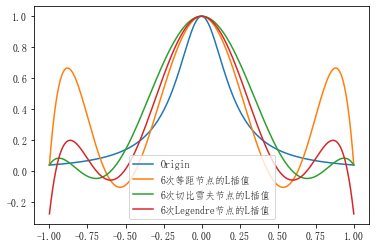

[-0.96028986 -0.79666648 -0.52553241 -0.18343464  0.18343464  0.52553241
  0.79666648  0.96028986]


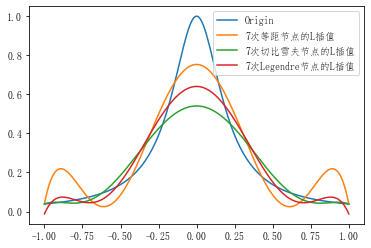

[-9.68160240e-01 -8.36031107e-01 -6.13371433e-01 -3.24253423e-01
 -1.02430027e-16  3.24253423e-01  6.13371433e-01  8.36031107e-01
  9.68160240e-01]


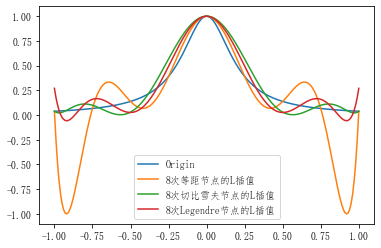

[-0.97390653 -0.86506337 -0.67940957 -0.43339539 -0.14887434  0.14887434
  0.43339539  0.67940957  0.86506337  0.97390653]


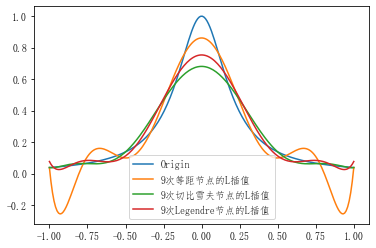

[-9.78228658e-01 -8.87062600e-01 -7.30152006e-01 -5.19096129e-01
 -2.69543156e-01 -1.45130929e-16  2.69543156e-01  5.19096129e-01
  7.30152006e-01  8.87062600e-01  9.78228658e-01]


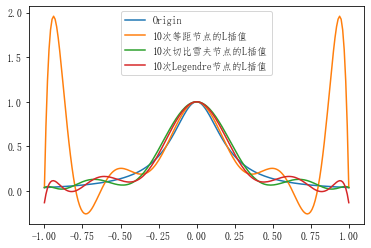

<Figure size 432x288 with 0 Axes>

In [34]:
N = 10
for n in range(N):
    # Lagrange 插值
    X1 = np.linspace(-1, 1, n + 2)
    Y1 = 1 / (1 + 25 * X1 ** 2)
    x1 = np.linspace(-1, 1, 200)
    y1 = lagrange(x1, X1, Y1)
    # 切比雪夫点的Lagrange插值
    X2 = chebP(n+2)
    Y2 = runge(X2)
    y2 = lagrange(x1, X2, Y2)
    # Legendre多项式根节点
    X3 = legendreP(n+2,alpha=0,beta=0,m=0)
    Y3 = runge(X3)
    print(X3)
    y3 = lagrange(x1, X3, Y3)
    plt.plot(X, Y, label='Origin')
    plt.plot(x1, y1, label=str(n + 1) + '次等距节点的L插值')
    plt.plot(x1, y2, label=str(n + 1) + '次切比雪夫节点的L插值')
    plt.plot(x1, y3, label=str(n + 1) + '次Legendre节点的L插值')
    plt.legend(loc='best')
    plt.show(block=False)
    plt.pause(1)
    plt.clf()

[-0.57735027  0.57735027]


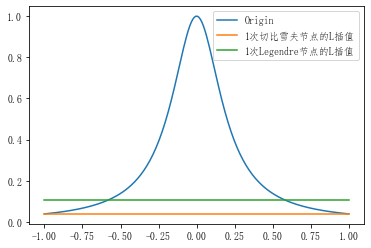

[-7.74596669e-01  4.33680869e-19  7.74596669e-01]


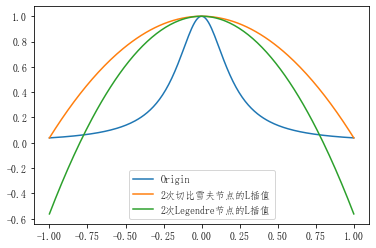

[-0.86113631 -0.33998104  0.33998104  0.86113631]


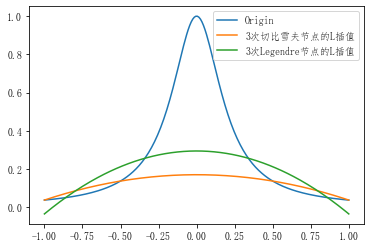

[-9.06179846e-01 -5.38469310e-01 -2.35690992e-17  5.38469310e-01
  9.06179846e-01]


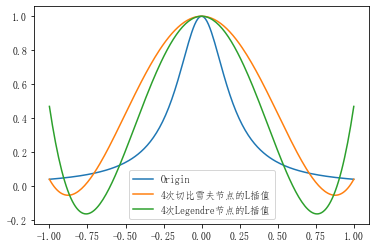

[-0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939  0.93246951]


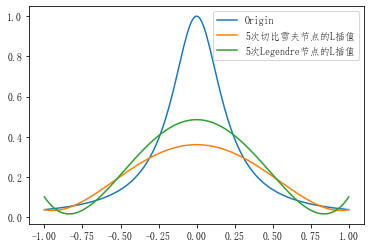

[-9.49107912e-01 -7.41531186e-01 -4.05845151e-01  6.33376116e-17
  4.05845151e-01  7.41531186e-01  9.49107912e-01]


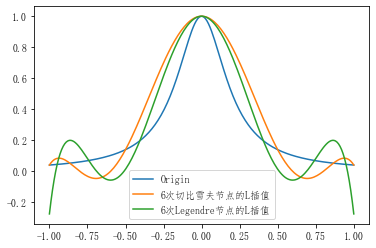

[-0.96028986 -0.79666648 -0.52553241 -0.18343464  0.18343464  0.52553241
  0.79666648  0.96028986]


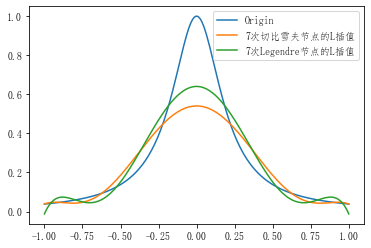

[-9.68160240e-01 -8.36031107e-01 -6.13371433e-01 -3.24253423e-01
 -1.02430027e-16  3.24253423e-01  6.13371433e-01  8.36031107e-01
  9.68160240e-01]


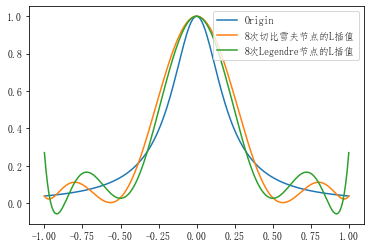

[-0.97390653 -0.86506337 -0.67940957 -0.43339539 -0.14887434  0.14887434
  0.43339539  0.67940957  0.86506337  0.97390653]


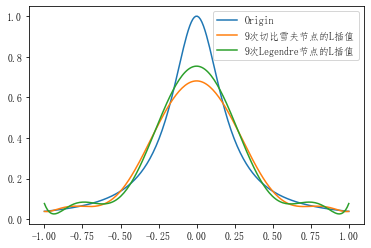

[-9.78228658e-01 -8.87062600e-01 -7.30152006e-01 -5.19096129e-01
 -2.69543156e-01 -1.45130929e-16  2.69543156e-01  5.19096129e-01
  7.30152006e-01  8.87062600e-01  9.78228658e-01]


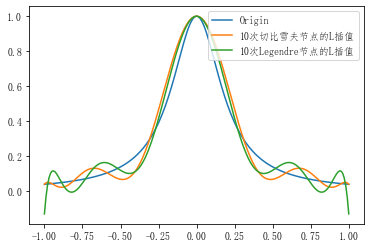

[-0.98156063 -0.90411726 -0.76990267 -0.58731795 -0.3678315  -0.12523341
  0.12523341  0.3678315   0.58731795  0.76990267  0.90411726  0.98156063]


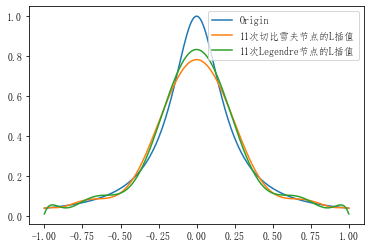

[-9.84183055e-01 -9.17598399e-01 -8.01578091e-01 -6.42349339e-01
 -4.48492751e-01 -2.30458316e-01 -2.06052212e-16  2.30458316e-01
  4.48492751e-01  6.42349339e-01  8.01578091e-01  9.17598399e-01
  9.84183055e-01]


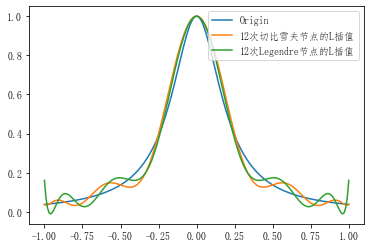

[-0.98628381 -0.92843488 -0.82720132 -0.6872929  -0.51524864 -0.31911237
 -0.10805495  0.10805495  0.31911237  0.51524864  0.6872929   0.82720132
  0.92843488  0.98628381]


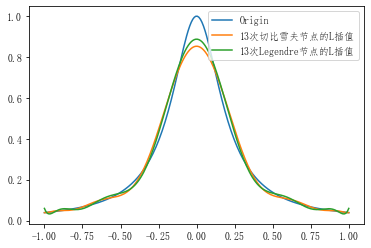

[-9.87992518e-01 -9.37273392e-01 -8.48206583e-01 -7.24417731e-01
 -5.70972173e-01 -3.94151347e-01 -2.01194094e-01 -1.61187959e-17
  2.01194094e-01  3.94151347e-01  5.70972173e-01  7.24417731e-01
  8.48206583e-01  9.37273392e-01  9.87992518e-01]


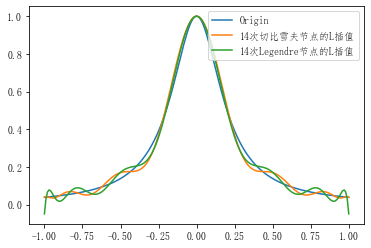

[-0.98940093 -0.94457502 -0.8656312  -0.75540441 -0.61787624 -0.45801678
 -0.28160355 -0.09501251  0.09501251  0.28160355  0.45801678  0.61787624
  0.75540441  0.8656312   0.94457502  0.98940093]


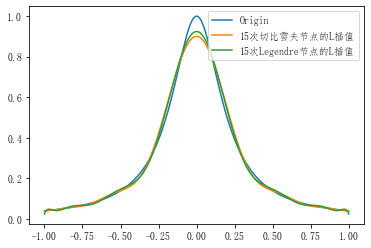

[-9.90575475e-01 -9.50675522e-01 -8.80239154e-01 -7.81514004e-01
 -6.57671159e-01 -5.12690537e-01 -3.51231763e-01 -1.78484181e-01
 -7.57600808e-17  1.78484181e-01  3.51231763e-01  5.12690537e-01
  6.57671159e-01  7.81514004e-01  8.80239154e-01  9.50675522e-01
  9.90575475e-01]


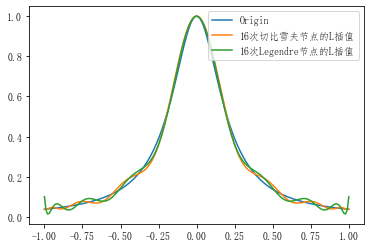

[-0.99156517 -0.95582395 -0.89260247 -0.80370496 -0.69168704 -0.55977083
 -0.41175116 -0.25188623 -0.08477501  0.08477501  0.25188623  0.41175116
  0.55977083  0.69168704  0.80370496  0.89260247  0.95582395  0.99156517]


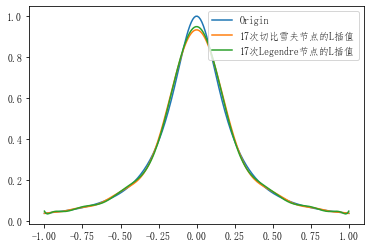

[-9.92406844e-01 -9.60208152e-01 -9.03155904e-01 -8.22714657e-01
 -7.20966177e-01 -6.00545305e-01 -4.64570741e-01 -3.16564100e-01
 -1.60358646e-01 -1.61472094e-16  1.60358646e-01  3.16564100e-01
  4.64570741e-01  6.00545305e-01  7.20966177e-01  8.22714657e-01
  9.03155904e-01  9.60208152e-01  9.92406844e-01]


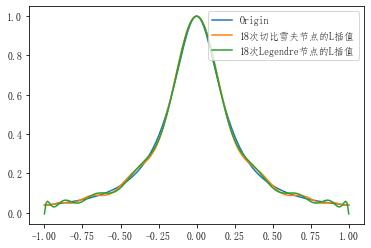

[-0.9931286  -0.96397193 -0.91223443 -0.83911697 -0.74633191 -0.63605368
 -0.510867   -0.37370609 -0.22778585 -0.07652652  0.07652652  0.22778585
  0.37370609  0.510867    0.63605368  0.74633191  0.83911697  0.91223443
  0.96397193  0.9931286 ]


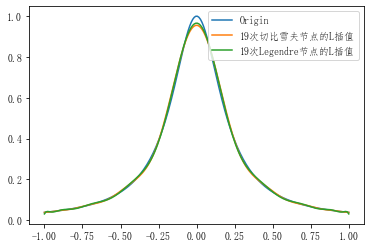

[-9.93752171e-01 -9.67226839e-01 -9.20099334e-01 -8.53363365e-01
 -7.68439963e-01 -6.67138804e-01 -5.51618836e-01 -4.24342120e-01
 -2.88021317e-01 -1.45561854e-01  1.16701506e-16  1.45561854e-01
  2.88021317e-01  4.24342120e-01  5.51618836e-01  6.67138804e-01
  7.68439963e-01  8.53363365e-01  9.20099334e-01  9.67226839e-01
  9.93752171e-01]


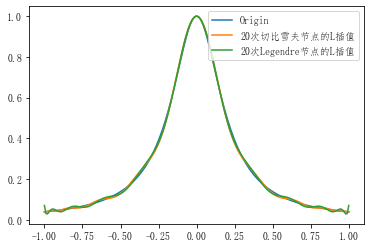

<Figure size 432x288 with 0 Axes>

In [36]:
N = 20
for n in range(N):
    # Lagrange 插值
    X1 = np.linspace(-1, 1, n + 2)
    Y1 = 1 / (1 + 25 * X1 ** 2)
    x1 = np.linspace(-1, 1, 200)
    y1 = lagrange(x1, X1, Y1)
    # 切比雪夫点的Lagrange插值
    X2 = chebP(n+2)
    Y2 = runge(X2)
    y2 = lagrange(x1, X2, Y2)
    # Legendre多项式根节点
    X3 = legendreP(n+2,alpha=0,beta=0,m=0)
    Y3 = runge(X3)
    print(X3)
    y3 = lagrange(x1, X3, Y3)
    plt.plot(X, Y, label='Origin')
    plt.plot(x1, y2, label=str(n + 1) + '次切比雪夫节点的L插值')
    plt.plot(x1, y3, label=str(n + 1) + '次Legendre节点的L插值')
    plt.legend(loc='best')
    plt.show(block=False)
    plt.pause(1)
    plt.clf()